# Reading Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils.general import read_raw_data

x, y, names = read_raw_data(score_path='labels/fts_score.csv', data_path='labels/fts_data.csv')
# TODO: code to combine fts and fco

all examples: 1371


1371it [00:37, 36.90it/s]


# Binary scoring

In [57]:
score_threshold = 6
labels = np.array(y)
labels[labels <= score_threshold] = 0
labels[labels > score_threshold] = 1
unique, counts = np.unique(labels, return_counts=True)
for idx, c in enumerate(counts):
    print(f'label: {idx}: {c} samples')

label: 0: 1101 samples
label: 1: 270 samples


# Config

In [3]:
## Network
HIDDEN_DIM = 64
OUTPUT_DIM = 2
BATCH_SIZE = 4
IS_BID = True
NUM_LAYERS = 2

## Optimizer  
lr = 1e-3
weight_decay=0.001

## Scheduler
step_size=3
gamma=0.5

early_stop_patience = 5

# Feature Selection

In [58]:
def feature_selection(remove_features):
    idxs = []
    for p in remove_features:
        idxs.extend(list(range(p*4, p*4 + 4)))
    return np.delete(x, idxs, axis=2)

head_landmarks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = feature_selection([])
print(data.shape)

NUM_FEATURES = 100 - (len([]) * 4)

torch.Size([1371, 50, 100])


# Augmentation

In [59]:
import pandas as pd
# currently simple sub sampling

def simple_subsample(data_, pos, neg):
    data_pos = data_[pos]
    data_neg = data_[neg]
    data_neg = data_neg[0:len(data_pos)]
    
    return np.concatenate((data_pos, data_neg), axis=0)

pos = np.where(labels==1)
neg = np.where(labels==0)

data = simple_subsample(data, pos, neg)
labels = simple_subsample(labels, pos, neg)

name_list = np.array(list(names.values()))
name_list = simple_subsample(name_list, pos, neg)
labels_names = pd.DataFrame({'label': labels, 'name': name_list})

print('x', data.shape)
print('y', labels.shape)
print('names', name_list.shape)

x (540, 50, 100)
y (540,)
names (540,)


# Data Set & Loaders

In [60]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels_names, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42,
                                                  stratify=y_train['label'])

class TTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels.iloc[idx]['label'], idx

def create_dataloaders(batch_size):
    train_data = TTDataset(x_train, y_train)
    test_data = TTDataset(x_test, y_test)
    validation_data = TTDataset(x_val, y_val)
    
    print('#train samples: ', len(train_data))
    print('#valid samples: ', len(validation_data))
    print('#test  samples: ', len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_loader, validation_loader, test_loader

    
train_loader, validation_loader, test_loader = create_dataloaders(BATCH_SIZE)

#train samples:  259
#valid samples:  173
#test  samples:  108


# Learning

In [61]:
import torch.nn as nn
import math

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.scale = 1. / math.sqrt(hidden_size)

    def forward(self, hidden, outputs):
        hidden = hidden.unsqueeze(1)
        values = outputs.transpose(0, 1)
        outputs = outputs.transpose(0, 1).transpose(1, 2)

        weights = torch.bmm(hidden, outputs)
        scores = F.softmax(weights.mul_(self.scale), dim=2)
        linear_combination = torch.bmm(scores, values).squeeze(1)
        return linear_combination


class Network(nn.Module):
    def __init__(self, input_dim, h_dim, out_dim, num_layers=1, bidirectional=True):
        super().__init__()
        self.num_layers = num_layers
        self.h_dim = h_dim
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(0.5)

        # Attention layer - unused so far
        hid_bidirectional = h_dim * 2 if bidirectional else h_dim
        self.atten = Attention(hid_bidirectional)

        # LSTM
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=h_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)  # dropout
        # FC layer
        self.fc = nn.Linear(hid_bidirectional, out_dim, bias=True)

        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        lay_times_dir = self.num_layers * 2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(lay_times_dir, BATCH_SIZE, HIDDEN_DIM).to(device)
        c0 = torch.zeros(lay_times_dir, BATCH_SIZE, HIDDEN_DIM).to(device)

        out, (h_t, c_t) = self.lstm(X, (h0, c0))
        if self.bidirectional:
            cell_state = torch.cat([c_t[-1], c_t[-2]], dim=1)
        else:
            cell_state = c_t[-1]

        y = self.fc(cell_state)
        yt_log_proba = self.log_softmax(y)
        return yt_log_proba

In [62]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


epoch 0 | train loss : 0.621713399887085 validation loss: 0.5510486960411072 
epoch 0 | train acc : 0.703125 validation acc: 0.7034883720930233 
epoch 1 | train loss : 0.5325115919113159 validation loss: 0.5265678763389587 
epoch 1 | train acc : 0.7109375 validation acc: 0.7034883720930233 
epoch 2 | train loss : 0.5202943086624146 validation loss: 0.5081400275230408 
epoch 2 | train acc : 0.7109375 validation acc: 0.7034883720930233 
epoch 3 | train loss : 0.49828916788101196 validation loss: 0.4842127859592438 
epoch 3 | train acc : 0.703125 validation acc: 0.6976744186046512 
epoch 4 | train loss : 0.47499674558639526 validation loss: 0.440106600522995 
epoch 4 | train acc : 0.7578125 validation acc: 0.7965116279069767 
epoch 5 | train loss : 0.46573665738105774 validation loss: 0.4642784595489502 
epoch 5 | train acc : 0.73828125 validation acc: 0.7093023255813954 
epoch 6 | train loss : 0.4565144181251526 validation loss: 0.4430895149707794 
epoch 6 | train acc : 0.76171875 valida

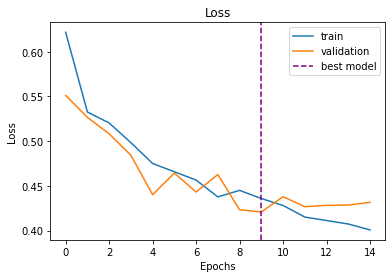

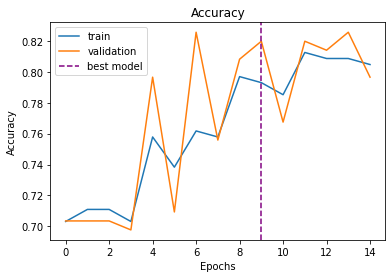

In [63]:
from utils.learn import train_model

model = Network(NUM_FEATURES, HIDDEN_DIM, OUTPUT_DIM,
                bidirectional=IS_BID, num_layers=NUM_LAYERS).to(device)
model_name = f'b{BATCH_SIZE}_lr{lr}_sz{step_size}_g{gamma}_h{HIDDEN_DIM}_nl{NUM_LAYERS}_no_head.pt' #no_head
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_model(model, model_name, BATCH_SIZE, device, early_stop_patience,
            train_loader, validation_loader, test_loader,
            optimizer, scheduler, loss_fn)

# False analysis 

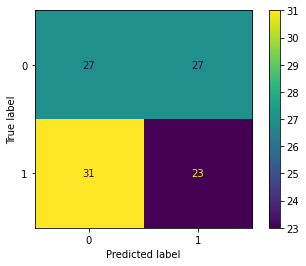

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utils.learn import predict
from visualization import points_visualization
from IPython.display import Image

model.load_state_dict(torch.load('model_results/' + model_name))
model.eval()
correct_idx, wrong_idx, y_pred = predict(model, test_loader, device, BATCH_SIZE)

cm = confusion_matrix(np.array(y_test['label']), np.array(y_pred), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [80]:
print('correct', correct_idx)
print('wrong', wrong_idx)
print()


debug_idx = 67

print('debug original idx in test set: ', debug_idx)
print('true label:', y_test.iloc[debug_idx]['label'])
print('correct:', debug_idx in correct_idx)

debug_name = y_test.iloc[debug_idx]['name']
debug_X = x_test[debug_idx]

# TODO: 1. this crash when using less then 100 features. 2. should not plot all images in the notebook
# points_visualization.create_gif_for_given_shot(debug_name, debug_X)


correct [20, 95, 49, 58, 55, 105, 4, 51, 64, 45, 3, 106, 24, 16, 102, 54, 8, 67, 70, 69, 78, 92, 0, 18, 47, 84, 86, 19, 107, 59, 71, 5, 2, 25, 39, 52, 101, 97, 61, 104, 103, 56, 22, 50, 62, 7, 81, 44, 32, 6, 65, 79, 83, 33, 99, 48, 43, 76, 15, 41, 91, 100, 82, 68, 42, 36, 31, 12, 53, 89, 38, 93, 34, 73, 75, 94, 60, 96, 30, 85, 35, 88, 63, 13]
wrong [77, 90, 72, 98, 74, 21, 57, 26, 37, 40, 87, 80, 66, 17, 1, 11, 10, 14, 28, 9, 23, 29, 27, 46]

debug original idx in test set:  67
true label: 1.0
correct: True


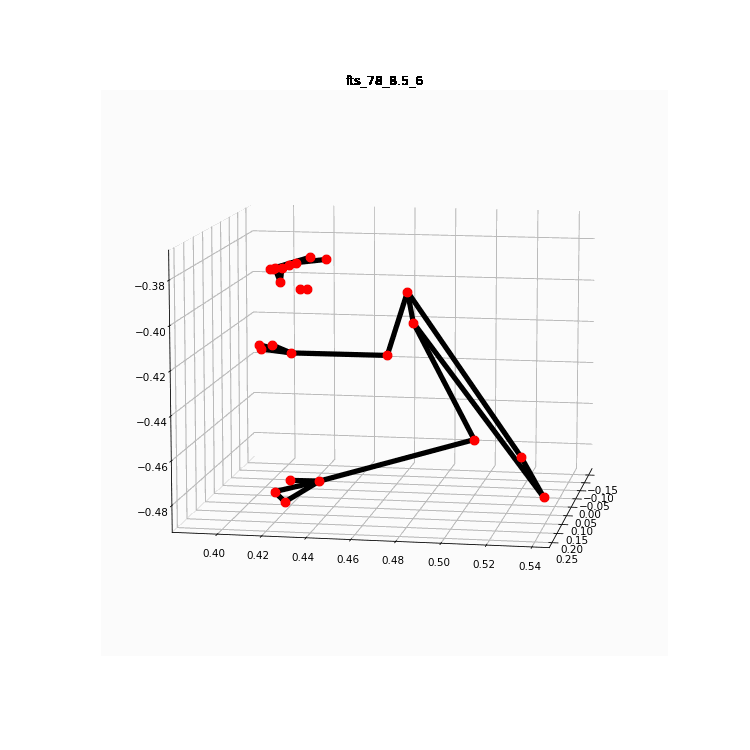

In [67]:
with open(f'visualization/shots_3d_demo/{debug_name}.gif','rb') as f:
    display(Image(data=f.read(), format='png'))